# Dependencies

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
import PIL
print(PIL.__version__)


CUDA is available!  Training on GPU ...
9.5.0


In [3]:
!ls /kaggle/input/the-simpsons-characters-dataset/simpsons_dataset

abraham_grampa_simpson	  homer_simpson        otto_mann
agnes_skinner		  kent_brockman        patty_bouvier
apu_nahasapeemapetilon	  krusty_the_clown     principal_skinner
barney_gumble		  lenny_leonard        professor_john_frink
bart_simpson		  lionel_hutz	       rainier_wolfcastle
carl_carlson		  lisa_simpson	       ralph_wiggum
charles_montgomery_burns  maggie_simpson       selma_bouvier
chief_wiggum		  marge_simpson        sideshow_bob
cletus_spuckler		  martin_prince        sideshow_mel
comic_book_guy		  mayor_quimby	       simpsons_dataset
disco_stu		  milhouse_van_houten  snake_jailbird
edna_krabappel		  miss_hoover	       troy_mcclure
fat_tony		  moe_szyslak	       waylon_smithers
gil			  ned_flanders
groundskeeper_willie	  nelson_muntz


In [4]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Sep 10 08:53:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             12W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

In [5]:
import pickle
import numpy as np
from skimage import io
import pandas as pd

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

import torch.optim as optim
from torchvision import transforms
import torchvision.models as models
from sklearn.metrics import f1_score
from multiprocessing.pool import ThreadPool
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.models as models

from matplotlib import colors, pyplot as plt
%matplotlib inline



# Dataset

In [6]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [7]:

class SimpsonsDataset(Dataset):
    """
    A dataset with pictures that simultaneously loads them from folders
    performs scaling and transformation into tensors
    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file).convert("RGB")  
        return image

    def __getitem__(self, index):
        # Define different transformations for train and validation/test modes
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
                transforms.RandomRotation(10),  # Randomly rotate the image by ±10 degrees
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        
        x = self.load_sample(self.files[index]) 
        x = transform(x)  
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        # No changes needed here as image processing is handled in __getitem__
        return image


In [8]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """
        Imshow for tensors
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [9]:
TRAIN_DIR = Path('/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset')

In [10]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [11]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [12]:
len(train_val_files), len(test_files)

(41866, 990)

In [13]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

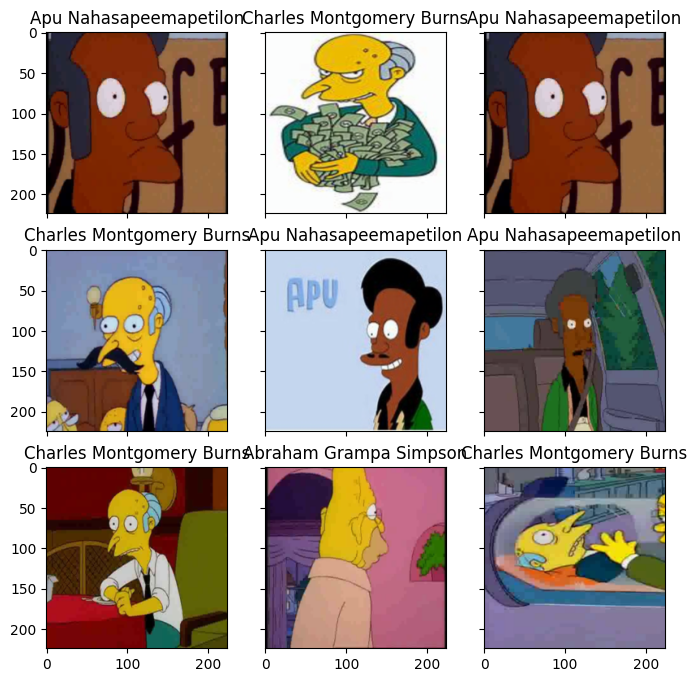

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Train loop and predict

In [15]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [17]:
def train(train_files, val_files, model, learning_rate, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    history = []
    log_template = "\n ------------ \nEpoch {ep:03d} || train loss: {t_loss:0.4f} | val loss {v_loss:0.4f} | train acc {t_acc:0.4f} | val acc {v_acc:0.4f}\n"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [18]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

# Model

## SimpleCNN with batch norm.

This is a modification of SimpleCNN with a batch norms to improve training. We also added Dropout for regularization.

In [19]:
class SimpleCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        logits = self.out(x)
        return logits

In [20]:
n_classes = len(np.unique(train_val_labels))
print(n_classes)

42


Based on the graph we got from traing simple_cnn with `lr=0.001, 0.005, 0.0001, 0.0005` we conclude that `lr=0.001` is the best parameter. `batch_size=64` because we have `42` classes and `64` is a closest number that is also a power of two.

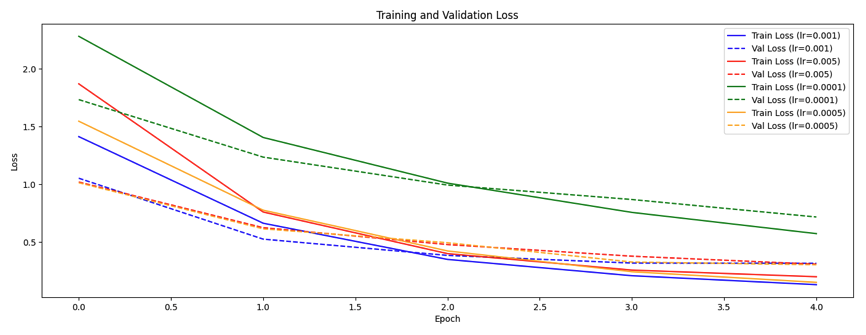

In [21]:
PIL.Image.open("/kaggle/input/lrdata/simple_cnn_train.png")

## SimpleCNN with AdamW 

In [22]:
def train(train_files, val_files, model, learning_rate, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    history = []
    log_template = "\n ------------ \nEpoch {ep:03d} || train loss: {t_loss:0.4f} | val loss {v_loss:0.4f} | train acc {t_acc:0.4f} | val acc {v_acc:0.4f}\n"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

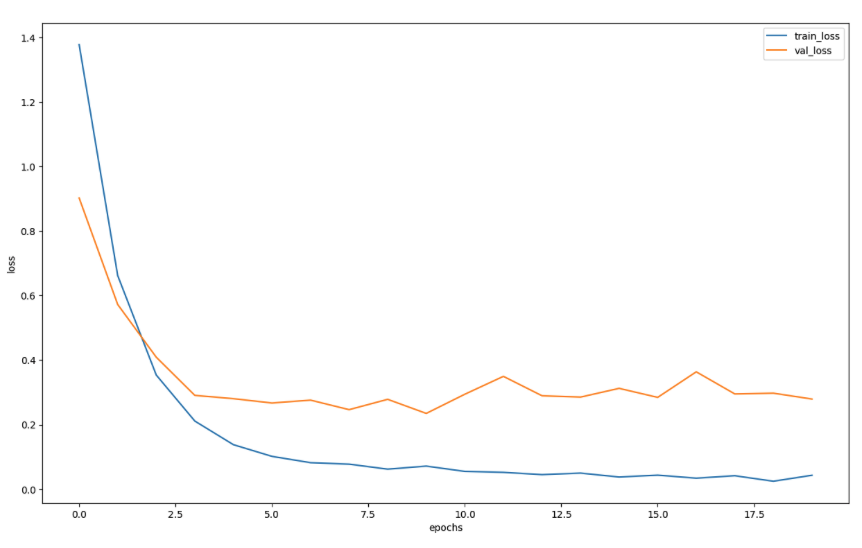

In [23]:
PIL.Image.open("/kaggle/input/traindata/simple_cnn.png")

Since we're low on resources we will train for the least amount possible.

In [24]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
history_simple_cnn_001 = train(train_dataset, val_dataset, model=simple_cnn, learning_rate = 0.001, epochs=10, batch_size=64)

epoch:  10%|█         | 1/10 [03:02<27:23, 182.61s/it]


 ------------ 
Epoch 001 || train loss: 1.8289 | val loss 1.1184 | train acc 0.5071 | val acc 0.6907



epoch:  20%|██        | 2/10 [05:41<22:27, 168.49s/it]


 ------------ 
Epoch 002 || train loss: 1.0740 | val loss 0.7678 | train acc 0.7087 | val acc 0.7918



epoch:  30%|███       | 3/10 [08:22<19:17, 165.32s/it]


 ------------ 
Epoch 003 || train loss: 0.7558 | val loss 0.6360 | train acc 0.7916 | val acc 0.8276



epoch:  40%|████      | 4/10 [11:02<16:18, 163.09s/it]


 ------------ 
Epoch 004 || train loss: 0.5829 | val loss 0.4821 | train acc 0.8386 | val acc 0.8679



epoch:  50%|█████     | 5/10 [13:40<13:27, 161.40s/it]


 ------------ 
Epoch 005 || train loss: 0.4796 | val loss 0.4049 | train acc 0.8649 | val acc 0.8901



epoch:  60%|██████    | 6/10 [16:17<10:39, 159.88s/it]


 ------------ 
Epoch 006 || train loss: 0.4092 | val loss 0.4043 | train acc 0.8833 | val acc 0.8919



epoch:  70%|███████   | 7/10 [18:55<07:57, 159.25s/it]


 ------------ 
Epoch 007 || train loss: 0.3619 | val loss 0.3625 | train acc 0.8954 | val acc 0.9061



epoch:  80%|████████  | 8/10 [21:33<05:17, 158.76s/it]


 ------------ 
Epoch 008 || train loss: 0.3247 | val loss 0.3802 | train acc 0.9073 | val acc 0.8983



epoch:  90%|█████████ | 9/10 [24:10<02:38, 158.31s/it]


 ------------ 
Epoch 009 || train loss: 0.2876 | val loss 0.2937 | train acc 0.9167 | val acc 0.9218



epoch: 100%|██████████| 10/10 [26:48<00:00, 160.89s/it]


 ------------ 
Epoch 010 || train loss: 0.2633 | val loss 0.2935 | train acc 0.9218 | val acc 0.9272



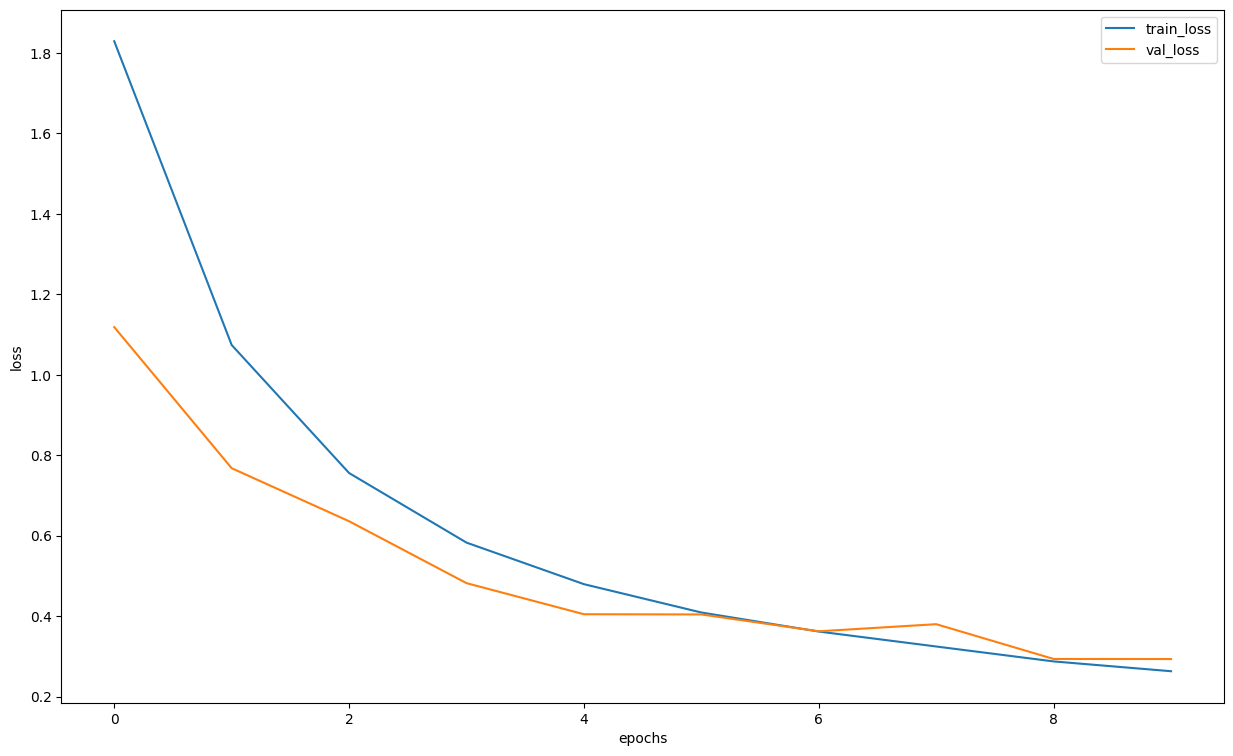

In [25]:
loss_001, acc_001, val_loss_001, val_acc_001 = zip(*history_simple_cnn_001)
plt.figure(figsize=(15, 9))
plt.plot(loss_001, label="train_loss")
plt.plot(val_loss_001, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## ResNET

In [26]:
class ResNet18(nn.Module):
    def __init__(self, n_classes):
        super(ResNet18, self).__init__()
        
        # Load a ResNet18 model
        self.resnet = models.resnet18(pretrained=False)  # Don't load pre-trained weights, I had some problems on kaggle with loading pretrained weighs so downloaded them from pytorch and uploaded as a model
        # Load weights from the local file
        state_dict = torch.load('/kaggle/input/resnet18/pytorch/default/1/resnet18-f37072fd.pth')
        self.resnet.load_state_dict(state_dict)

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, n_classes)

    def forward(self, x):
        return self.resnet(x)

In [27]:
def train(train_files, val_files, model, learning_rate, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)  # Decrease LR by a factor of 0.1 every 7 epochs
    
    criterion = nn.CrossEntropyLoss()
    history = []
    log_template = "\n ------------ \nEpoch {ep:03d} || train loss: {t_loss:0.4f} | val loss {v_loss:0.4f} | train acc {t_acc:0.4f} | val acc {v_acc:0.4f} | lr {lr:0.6f}\n"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            model.train()  
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)

            model.eval() 
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            scheduler.step()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, lr=scheduler.get_last_lr()[0]))

    return history


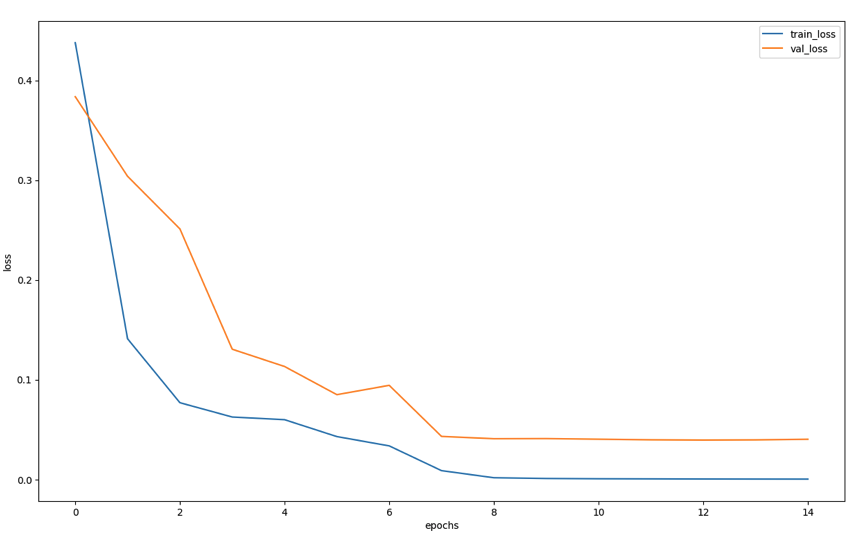

In [28]:
PIL.Image.open("/kaggle/input/traindata/resnet.png")

We will use `ResNet18` with scheduled decreasing learning rate starting from `0.001` and `batch_size=64` same sa before. `epochs=15` should be more than enough for a pre-trained model.

In [29]:
resnet = ResNet18(n_classes).to(DEVICE)
history_resnet = train(train_dataset, val_dataset, model=resnet, learning_rate = 0.001, epochs=10, batch_size=64)

epoch:  10%|█         | 1/10 [02:54<26:14, 174.99s/it]


 ------------ 
Epoch 001 || train loss: 0.5517 | val loss 0.3599 | train acc 0.8604 | val acc 0.9030 | lr 0.001000



epoch:  20%|██        | 2/10 [05:51<23:25, 175.74s/it]


 ------------ 
Epoch 002 || train loss: 0.2357 | val loss 0.4010 | train acc 0.9365 | val acc 0.8943 | lr 0.001000



epoch:  30%|███       | 3/10 [08:48<20:35, 176.52s/it]


 ------------ 
Epoch 003 || train loss: 0.1727 | val loss 0.2015 | train acc 0.9522 | val acc 0.9451 | lr 0.001000



epoch:  40%|████      | 4/10 [11:44<17:36, 176.05s/it]


 ------------ 
Epoch 004 || train loss: 0.1315 | val loss 0.1272 | train acc 0.9643 | val acc 0.9638 | lr 0.001000



epoch:  50%|█████     | 5/10 [14:39<14:39, 175.94s/it]


 ------------ 
Epoch 005 || train loss: 0.1056 | val loss 0.1210 | train acc 0.9709 | val acc 0.9671 | lr 0.001000



epoch:  60%|██████    | 6/10 [17:36<11:45, 176.37s/it]


 ------------ 
Epoch 006 || train loss: 0.0976 | val loss 0.1283 | train acc 0.9721 | val acc 0.9669 | lr 0.001000



epoch:  70%|███████   | 7/10 [20:33<08:49, 176.36s/it]


 ------------ 
Epoch 007 || train loss: 0.0870 | val loss 0.1007 | train acc 0.9752 | val acc 0.9714 | lr 0.000100



epoch:  80%|████████  | 8/10 [23:29<05:52, 176.43s/it]


 ------------ 
Epoch 008 || train loss: 0.0257 | val loss 0.0309 | train acc 0.9927 | val acc 0.9911 | lr 0.000100



epoch:  90%|█████████ | 9/10 [26:26<02:56, 176.34s/it]


 ------------ 
Epoch 009 || train loss: 0.0142 | val loss 0.0264 | train acc 0.9964 | val acc 0.9920 | lr 0.000100



epoch: 100%|██████████| 10/10 [29:21<00:00, 176.17s/it]


 ------------ 
Epoch 010 || train loss: 0.0102 | val loss 0.0222 | train acc 0.9975 | val acc 0.9936 | lr 0.000100



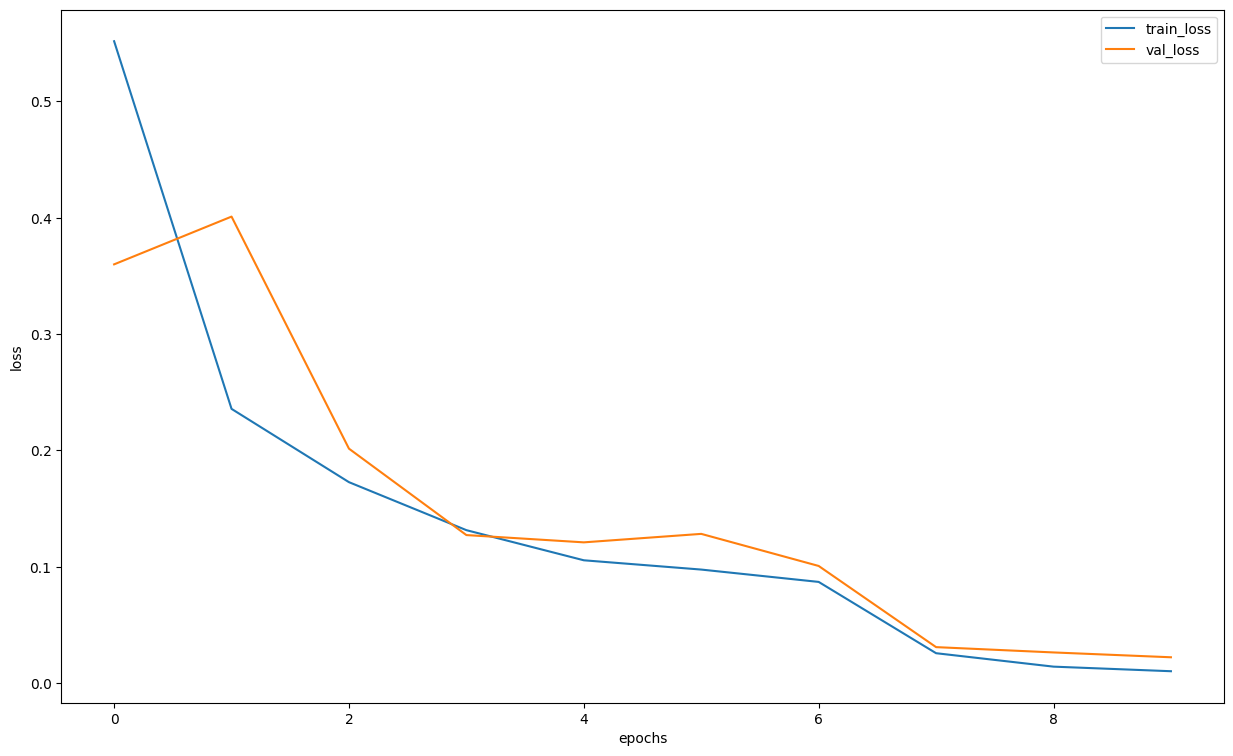

In [30]:
loss, acc, val_loss, val_acc = zip(*history_resnet)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [31]:
torch.save(resnet.state_dict(), 'resnet_weights.pth')

# Metrics

In [32]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [33]:
def get_f1score(model):   
    random_characters = int(np.random.uniform(0,1000))
    ex_img, true_label = val_dataset[random_characters]
    probs_im = predict_one_sample(resnet, ex_img.unsqueeze(0))

    idxs = list(map(int, np.random.uniform(0,1000, 20)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)

    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

    y_pred = np.argmax(probs_ims,-1)

    actual_labels = [val_dataset[id][1] for id in idxs]

    preds_class = [label_encoder.classes_[i] for i in y_pred]

    f1 = f1_score(actual_labels, y_pred, average='micro')

    print("F1-score:", f1)


In [34]:
get_f1score(simple_cnn)

F1-score: 0.9


In [35]:
get_f1score(resnet)

F1-score: 0.9500000000000001


We see that `ResNet18` outperformed `SimpleCNN` nad got a perfect score. Score of `0.9` for `SimpleCNN` is also a good performance for a very simple model.

# Result

In [36]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [37]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64, num_workers=4)

In [38]:
def get_test_res(model):
    probs = predict(model, test_loader)

    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    test_filenames = [path.name for path in test_dataset.files]
    
    return test_filenames, preds

In [39]:
resnet_res = get_test_res(resnet)

In [40]:
def res_to_csv(file_name, test_filenames, preds):
    #my_submit = pd.read_csv(file_name)
    my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
    my_submit.head()
    return my_submit

In [41]:
df = res_to_csv("submission.csv", resnet_res[0], resnet_res[1])
df.to_csv('simpsons_submission.csv', index=False)

In [42]:
df

,Image_id,Expected
0,abraham_grampa_simpson_0.jpg,abraham_grampa_simpson
1,abraham_grampa_simpson_1.jpg,abraham_grampa_simpson
2,abraham_grampa_simpson_10.jpg,abraham_grampa_simpson
3,abraham_grampa_simpson_11.jpg,abraham_grampa_simpson
4,abraham_grampa_simpson_12.jpg,abraham_grampa_simpson
...,...,...
985,sideshow_bob_49.jpg,sideshow_bob
986,sideshow_bob_5.jpg,sideshow_bob
987,sideshow_bob_7.jpg,sideshow_bob
988,sideshow_bob_8.jpg,sideshow_bob


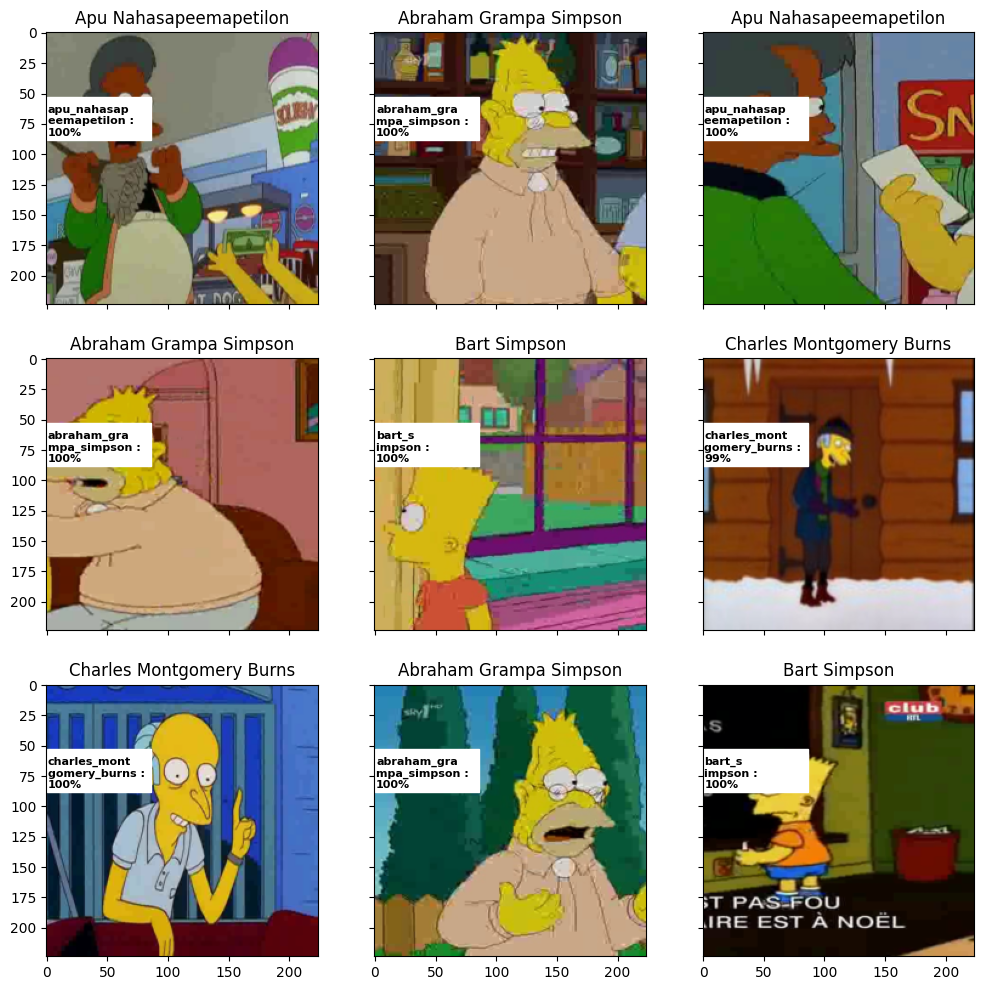

In [43]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(resnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : \n{:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')